In [1]:
!pip install albumentations > /dev/null
!git clone https://github.com/qubvel/efficientnet.git
!pip install console_progressbar

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Cloning into 'efficientnet'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 765.78 KiB | 0 bytes/s, done.
Resolving deltas: 100% (68/68), done.
  Stored in directory: /tmp/.cache/pip/wheels/76/75/2c/d26751f4f3d2cd72d58d10313113691e87995630c89aab231b
Successfully built console-progressbar
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# This preprocessing portion of the code is provided by foamliu on his github repo
# https://github.com/foamliu/Car-Recognition/blob/master/pre-process.py

import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
from console_progressbar import ProgressBar

In [3]:
def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
def save_train_data(fnames, labels, bboxes):
    src_folder ='../input/stanford-cars-dataset/cars_train/cars_train/'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        if i in train_indexes:
            dst_folder = '/kaggle/working/data/train/'
        else:
            dst_folder = '/kaggle/working/data/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [5]:
def save_test_data(fnames, bboxes):
    src_folder = '../input/stanford-cars-dataset/cars_test/cars_test/'
    dst_folder = '/kaggle/working/data/test/'
    num_samples = len(fnames)

    pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print(fname)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [6]:
def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('../input/cars-devkit/cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)

In [7]:
def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('../input/cars-devkit/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)

In [8]:
img_width, img_height = 224, 224

cars_meta = scipy.io.loadmat('../input/cars-devkit/cars_meta.mat')
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)
print('class_names.shape: ' + str(class_names.shape))
print('Sample class_name: [{}]'.format(class_names[8][0][0]))

ensure_folder('/kaggle/working/data/train')
ensure_folder('/kaggle/working/data/valid')
ensure_folder('/kaggle/working/data/test')

process_train_data()
process_test_data()

class_names.shape: (196, 1)
Sample class_name: [Aston Martin V8 Vantage Coupe 2012]
Processing train data...
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The number of different cars is 196
Save train data |==========================================

In [9]:
import os
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import keras
import pandas as pd
from PIL import Image
import cv2

from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.imagenet_utils import decode_predictions

from efficientnet import EfficientNetB0,EfficientNetB3
from efficientnet import center_crop_and_resize, preprocess_input
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [10]:
# from keras.utils import plot_model
# from keras.models import Model
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import Activation
# from keras.layers import Dropout
# from keras.layers import Maximum
# from keras.layers import ZeroPadding2D
# from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D,AveragePooling2D
# from keras.layers.merge import concatenate
# from keras import regularizers
# from keras.layers import BatchNormalization
# from keras.optimizers import Adam, SGD
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras.layers.advanced_activations import LeakyReLU
# from keras.utils import to_categorical

# from sklearn.model_selection import StratifiedKFold
# from skimage.transform import resize as imresize
# from tqdm import tqdm


In [11]:
def plot_loss_acc(history):
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'][1:])    
    plt.plot(history.history['val_loss'][1:])    
    plt.title('model loss')    
    plt.ylabel('val_loss')    
    plt.xlabel('epoch')    
    plt.legend(['Train','Validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [12]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
#             callbacks.ModelCheckpoint("./keras.model",monitor='val_loss', 
#                                    mode = 'min', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

import keras.callbacks as callbacks

class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [13]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=20.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=[0.9, 1.25],
        brightness_range=[0.5, 1.5],
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './data/train',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        './data/valid',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.


In [14]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, num_classes):

    x = base_model.output
    
    x = AveragePooling2D((5, 5), name='avg_pool')(x)
    x = Flatten()(x)
    x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='softmax', name='finalfc')(x)
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [15]:
HEIGHT = 299
WIDTH = 299

input_shape=(HEIGHT, WIDTH, 3)

dropout = 0.7
epochs = 100
swa = SWA('./keras_swa.model',epochs-3)

base_model = EfficientNetB3(weights='imagenet',
                            include_top=False,
                            input_shape=(HEIGHT, WIDTH, 3))

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      num_classes=196)

finetune_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)

history = finetune_model.fit_generator(generator=train_generator,
                                        validation_data=validation_generator,
                                        steps_per_epoch=150,
                                        epochs=epochs,verbose=2,validation_steps=55,callbacks=snapshot.get_callbacks())

try:
    finetune_model.load_weights('./keras_swa.model')
except Exception as e:
    print(e)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
43974656/43966704 [==============================] - 0s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Stochastic weight averaging selected for last 3 epochs.
Epoch 1/100
 - 182s - loss: 5.1134 - acc: 0.0344 - val_loss: 4.3417 - val_acc: 0.0990
Epoch 2/100
 - 149s - loss: 3.5732 - acc: 0.1958 - val_loss: 2.5807 - val_acc: 0.3597
Epoch 3/100
 - 149s - loss: 2.3726 - acc: 0.4010 - val_loss: 1.7762 - val_acc: 0.5492
Epoch 4/100
 - 150s - loss: 1.6006 - acc: 0.5579 - val_loss: 1.1948 - val_acc: 0.6705
Epoch 5/100
 - 150s - loss: 1.1093 - acc: 0.6812 - val_loss: 1.2267 - val_acc: 0.6784
Epoch 6/100
 - 149s - loss: 0.8

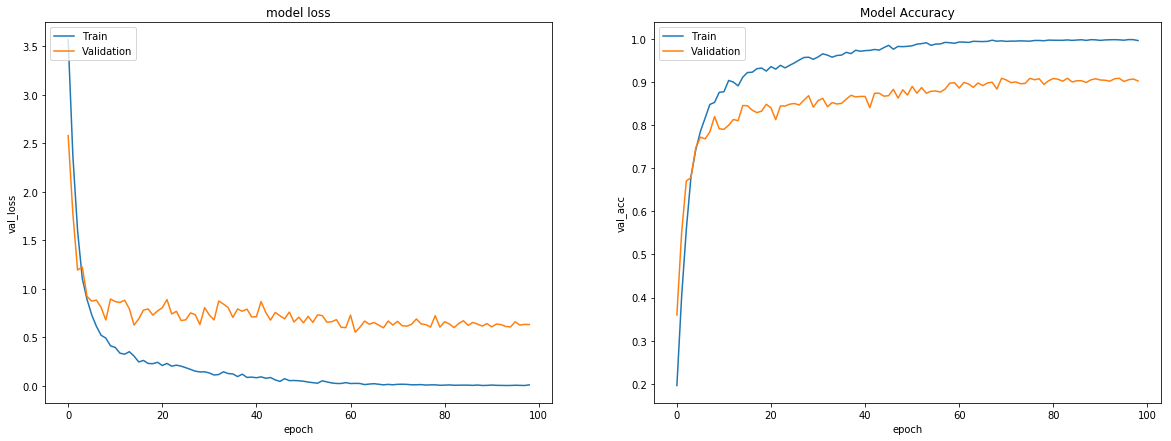

In [16]:
plot_loss_acc(history)

In [17]:
from tqdm import tqdm_notebook
import scipy.io as sio

num_samples,all_preds = 8041,[]
out = open('result.txt', 'a')
for i in tqdm_notebook(range(num_samples)):
    filename = os.path.join('./data/test', '%05d.jpg' % (i + 1))
    bgr_img = cv.imread(filename)
    rgb_img = cv.resize(cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)/255,(299,299))
    rgb_img = np.expand_dims(rgb_img, 0)
    preds = finetune_model.predict(rgb_img)
    class_id = np.argmax(preds)
    all_preds.append(class_id)
    out.write('{}\n'.format(str(class_id + 1)))
    
out.close()

In [18]:
labels = sio.loadmat('../input/cars-devkit/cars_test_annos_withlabels.mat')
actual_preds = np.array(labels['annotations']['class'],dtype=np.int)-1;
actual_preds = actual_preds.squeeze()
all_preds = np.array(all_preds)

In [19]:
print('accuracy = ',(all_preds==actual_preds).sum()/len(actual_preds))

accuracy =  0.9080960079592091


In [20]:
!rm -rf efficientnet/

In [21]:
!rm -rf data/